# Bone Age Prediction (InceptionV3)
Kunlun Liu

Blog Link
https://medium.com/@kunlun.liu/bone-age-prediction-with-x-rays-758fd113646a

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 

In [2]:
base_bone_dir = os.path.join('D:\\', 'PyCharm Files',"image")
age_df = pd.read_csv(os.path.join(base_bone_dir, 'boneage-training-dataset.csv'))
age_df['path'] = age_df['id'].map(lambda x: os.path.join(base_bone_dir,
                                                         'boneage-training-dataset', 
                                                         '{}.png'.format(x)))
age_df['exists'] = age_df['path'].map(os.path.exists)
print(age_df['exists'].sum(), 'images found of', age_df.shape[0], 'total')
age_df['gender'] = age_df['male'].map(lambda x: 'male' if x else 'female')
boneage_mean = age_df['boneage'].mean()
boneage_div = 2*age_df['boneage'].std()
age_df['boneage_zscore'] = age_df['boneage'].map(lambda x: (x-boneage_mean)/boneage_div)
age_df.dropna(inplace = True)
age_df.sample(3)

12611 images found of 12611 total


,id,boneage,male,path,exists,gender,boneage_zscore
1656,3223,162,False,D:\PyCharm Files\image\boneage-training-datase...,True,female,0.421048
5278,7426,108,True,D:\PyCharm Files\image\boneage-training-datase...,True,male,-0.234578
7544,9941,204,True,D:\PyCharm Files\image\boneage-training-datase...,True,male,0.930980


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002006D14D080>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000020070D68470>]], dtype=object)

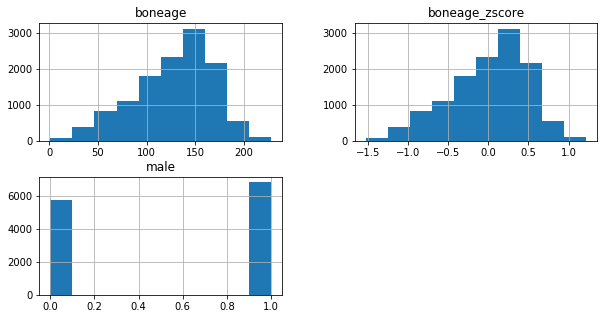

In [3]:
age_df[['boneage', 'male', 'boneage_zscore']].hist(figsize = (10, 5))

New Data Size: 10000 Old Size: 12611


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020070F53780>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000020070FD57F0>]], dtype=object)

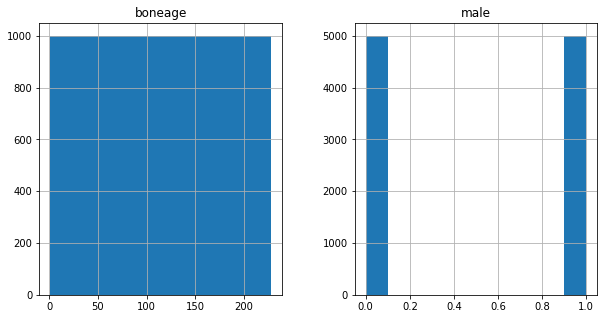

In [4]:
age_df['boneage_category'] = pd.cut(age_df['boneage'], 10)
new_age_df = age_df.groupby(['boneage_category', 'male']).apply(lambda x: x.sample(500, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', new_age_df.shape[0], 'Old Size:', age_df.shape[0])
new_age_df[['boneage', 'male']].hist(figsize = (10, 5))

In [5]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(new_age_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = new_age_df['boneage_category'])
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 7500 validation 2500


In [6]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (224, 224)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 10, 
                              shear_range = 0.05,
                              fill_mode = 'reflect',
                              zoom_range=0.10)

Using TensorFlow backend.


In [7]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [8]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 8)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 1024)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 7500 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2500 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2500 images


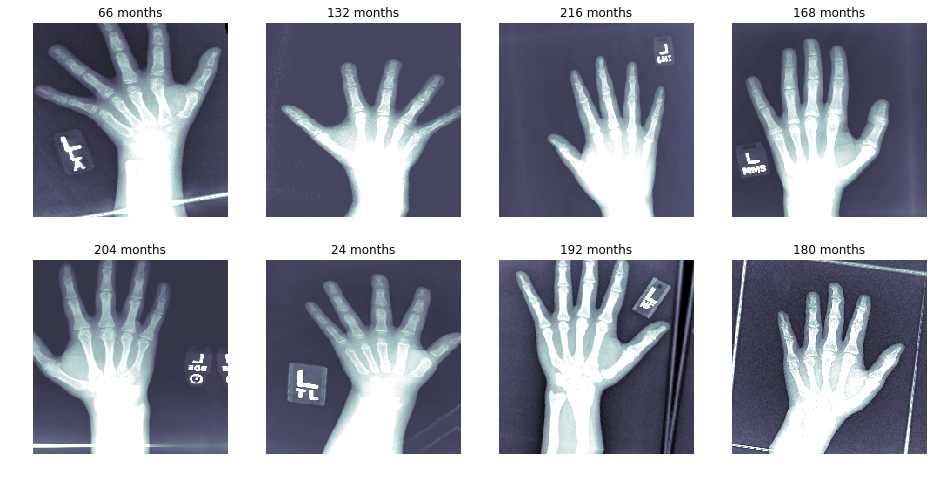

In [9]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title('%2.0f months' % (c_y*boneage_div+boneage_mean))
    c_ax.axis('off')

# Build pre-trained model using InceptionV3

In [10]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
#input_tensor = Input(shape=(224, 224, 3))
base_iv3_model = InceptionV3(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_iv3_model.trainable = False
bone_age_model = Sequential()
bone_age_model.add(base_iv3_model)
bone_age_model.add(GlobalAveragePooling2D())
bone_age_model.add(Dropout(0.5))
bone_age_model.add(Dense(1024, activation = 'relu'))
#bone_age_model.add(Dropout(0.25))
bone_age_model.add(Dense(1, activation = 'linear')) # linear is what 16bit did
from keras.metrics import mean_absolute_error
def mae_months(in_gt, in_pred):
    return mean_absolute_error(boneage_div*in_gt, boneage_div*in_pred)

bone_age_model.compile(optimizer = 'adam', loss = 'mse',
                           metrics = [mae_months])

bone_age_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 23,901,985
Trainable params: 2,099,201
Non-trainable params: 21,802,784
_________________________________________________________________


In [11]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('bone_age')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [15]:
history.history.keys()

dict_keys(['val_loss', 'val_mae_months', 'loss', 'mae_months', 'lr'])

In [12]:
history = bone_age_model.fit_generator(train_gen, 
                            steps_per_epoch=3,#300,
                            validation_data = (test_X, test_Y), 
                            epochs = 1,#4 
                            callbacks = callbacks_list)

Epoch 1/1
3/3 [==============================] - 246s 82s/step - loss: 9.3621 - mae_months: 209.9456 - val_loss: 21.9208 - val_mae_months: 373.0386

Epoch 00001: val_loss improved from inf to 21.92078, saving model to bone_age_weights.best.hdf5


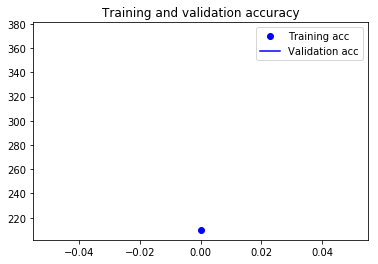

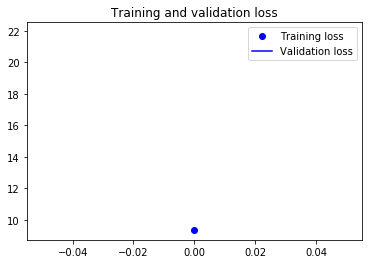

In [16]:
import matplotlib.pyplot as plt

acc = history.history['mae_months']
val_acc = history.history['val_mae_months']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Evaluate the results

In [17]:
bone_age_model.load_weights(weight_path)

In [18]:
pred_Y = boneage_div*bone_age_model.predict(test_X, batch_size = 32, verbose = True)+boneage_mean
test_Y_months = boneage_div*test_Y+boneage_mean

1024/1024 [==============================] - 239s 233ms/step


Text(0,0.5,'Predicted Age (Months)')

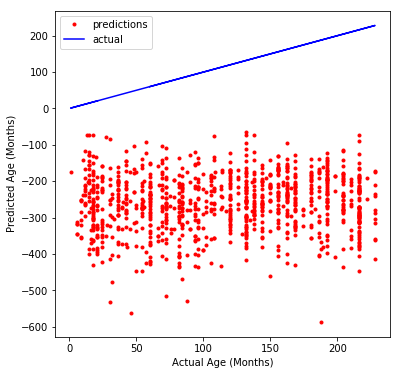

In [19]:
fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(test_Y_months, pred_Y, 'r.', label = 'predictions')
ax1.plot(test_Y_months, test_Y_months, 'b-', label = 'actual')
ax1.legend()
ax1.set_xlabel('Actual Age (Months)')
ax1.set_ylabel('Predicted Age (Months)')

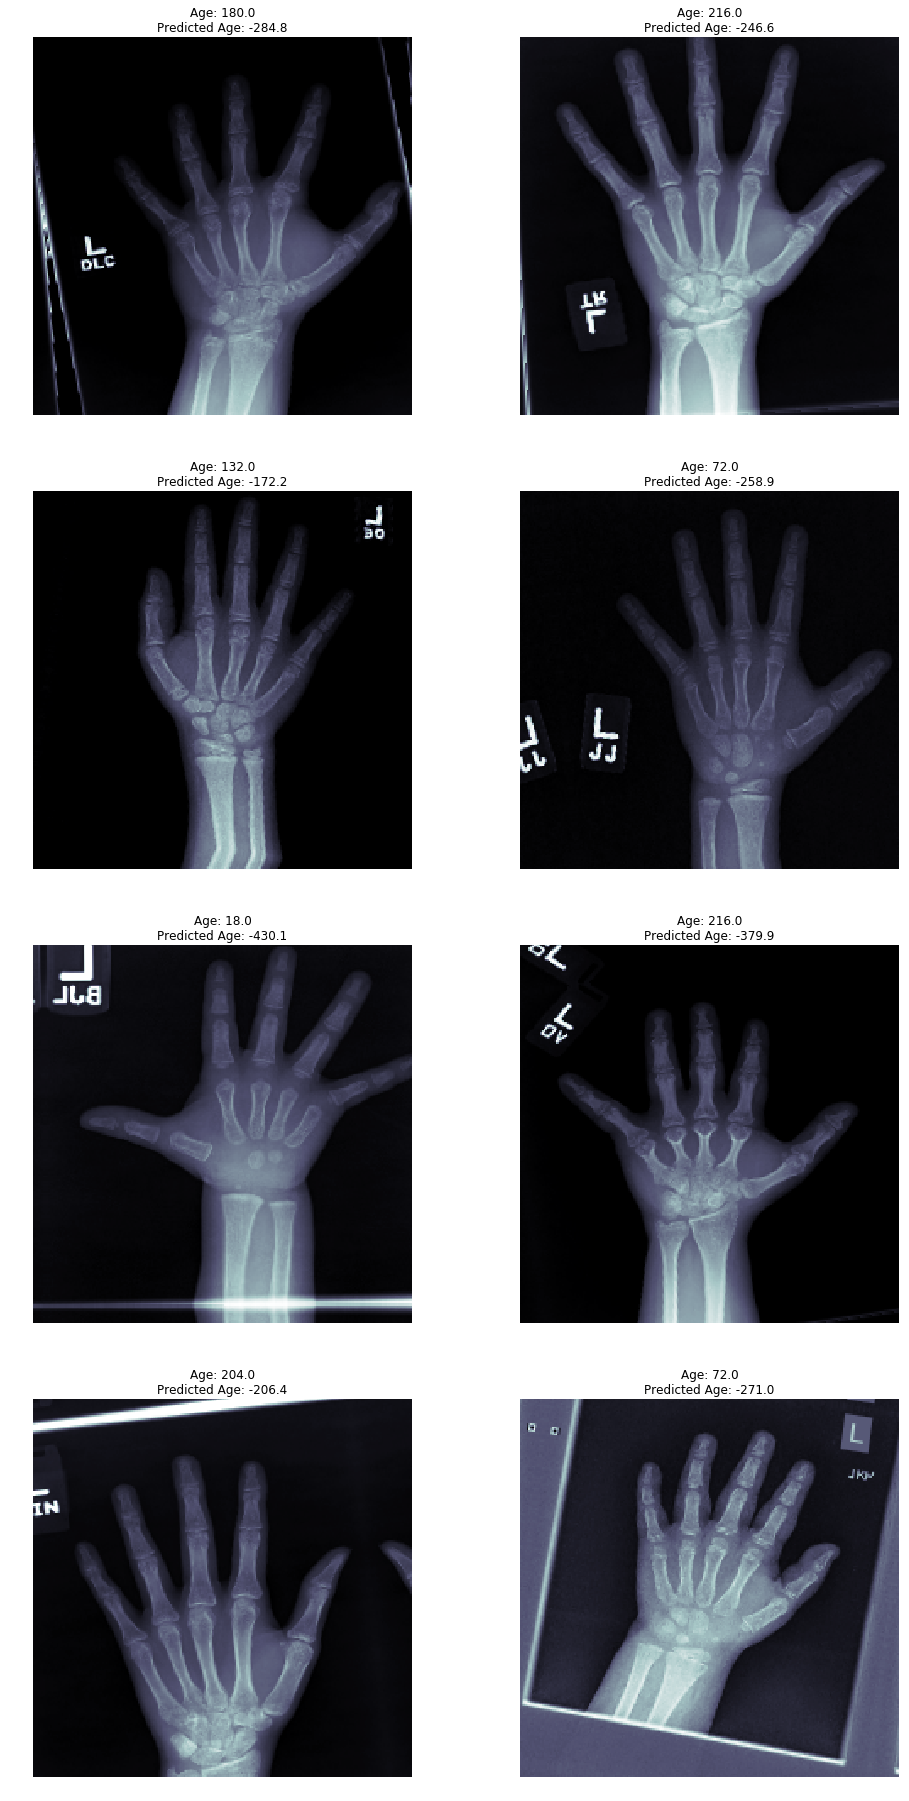

In [20]:
rand_idx = np.random.choice(range(test_X.shape[0]), 8)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(rand_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    
    c_ax.set_title('Age: %2.1f\nPredicted Age: %2.1f' % (test_Y_months[idx], pred_Y[idx]))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png', dpi = 300)